In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def mse(a, b, prec=2):
    return np.round(mean_squared_error(a, b), prec)

# Generate data

In [3]:
# Generating 1 dimensional data

a = 5
b = 10
n_points = 300
x_min = 0.5
x_max = 4

X = np.linspace(x_min, x_max, n_points)[:, np.newaxis]
rs = np.random.RandomState(33)
noise = rs.normal(0, 5, (n_points, 1))

y = a + b * X + noise

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=33)

In [7]:
X_train.shape

(99, 1)

In [8]:
y_train.shape

(99, 1)

In [9]:
from sklearn.linear_model import LinearRegression

In [ ]:
LinearRegression()

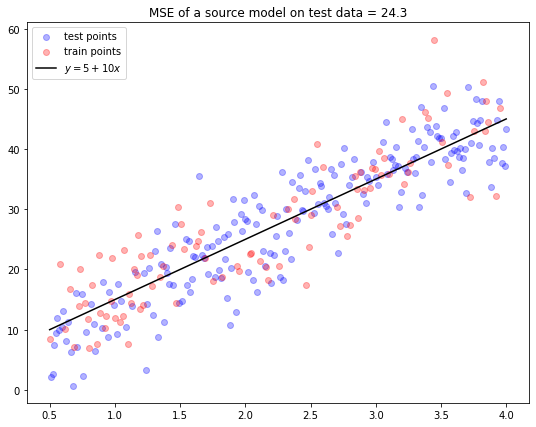

In [4]:
plt.figure(figsize=(9, 7))
plt.scatter(X_test, y_test, c='b', alpha=0.3, label='test points')
plt.scatter(X_train, y_train, c='r', alpha=0.3, label='train points')
plt.plot([0.5, 4], [10, 45], c='black', lw=1.5, label=f'$y = {a}+{b}x$');
plt.legend();
plt.title(f'MSE of a source model on test data = {np.round(mse(a+b*X_test, y_test), 2)}');

# 1. Linear model

$y = w_0 + w_1X_1 + w_2 X_2 + \ldots + w_k X_k$

---

$k = 1, X_1 = x$

$y = w_0 + w_1x$

In [10]:
from sklearn.linear_model import LinearRegression

Train MSE: 29.1 Test MSE: 25.0


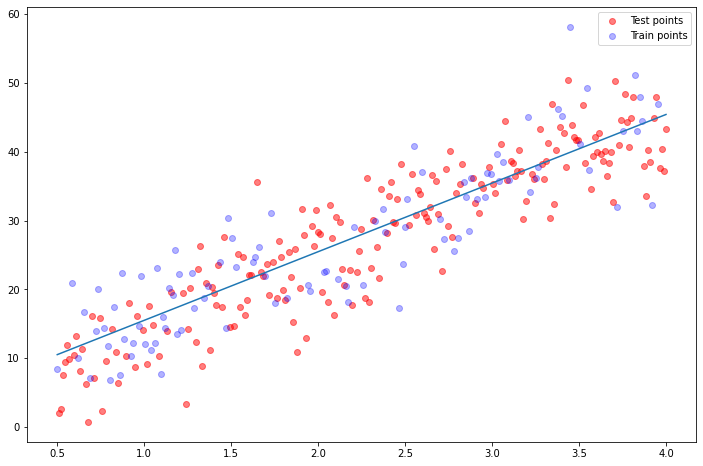

In [11]:
reg = LinearRegression()

# Train a model
reg.fit(X_train, y_train)

# Make predictions
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Compute an error
print('Train MSE:', mse(y_pred_train, y_train),
      'Test MSE:', mse(y_pred_test, y_test))

# Plot predicted model
X_linspace = np.linspace(0.5,4,200)[:, np.newaxis]
y_pred_linspace = reg.predict(X_linspace)

plt.figure(figsize=(12, 8))
plt.plot(X_linspace, y_pred_linspace)
plt.scatter(X_test, y_test, alpha=.5,c='r', label='Test points');
plt.scatter(X_train, y_train, alpha=.3, c='b', label='Train points');
plt.legend();

In [12]:
reg.coef_, reg.intercept_

(array([[9.9710629]]), array([5.53745896]))

### What if we add more (redundant) polynomial features, could we do better on train?

$y = w_0 + w_1X_1 + w_2 X_2 + \ldots + w_k X_k$

$k = 15, X_1 = x, X_2 = x^2, \ldots, X_{15}=x^{15}$

$$y = w_0 + w_1x + w_2 x^2 + \ldots + w_{15} x^{15} $$

In [13]:
from sklearn.preprocessing import PolynomialFeatures

In [14]:
poly = PolynomialFeatures(degree=15, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [15]:
reg = LinearRegression(fit_intercept=True)
reg.fit(X_train_poly, y_train)
y_pred_train = reg.predict(X_train_poly)
y_pred_test = reg.predict(X_test_poly)

print('Train MSE:', mse(y_pred_train, y_train),
      'Test MSE:', mse(y_pred_test, y_test))

Train MSE: 23.21 Test MSE: 30.13


### 1.1 Prediction curve

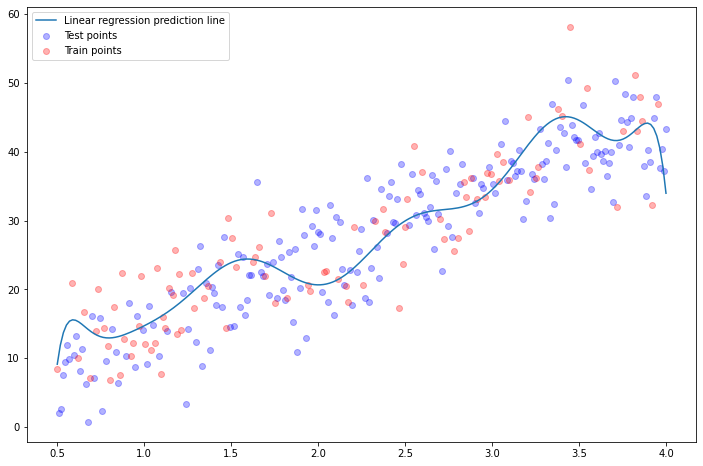

In [16]:
X_linspace_poly = poly.fit_transform(np.linspace(0.5,4,200).reshape(-1,1))
y_pred_linspace = reg.predict(X_linspace_poly)

plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0.5,4,200), y_pred_linspace, label='Linear regression prediction line')
plt.scatter(X_test, y_test, alpha=.3,c='b', label = 'Test points');

plt.scatter(X_train, y_train, alpha=.3, c='r', label='Train points');
plt.legend();

In [17]:
reg.coef_

array([[ 4.05388287e+04, -1.36901106e+05,  2.48553054e+05,
        -2.41851621e+05,  6.44469875e+04,  1.47515880e+05,
        -2.32085334e+05,  1.81225412e+05, -9.19257483e+04,
         3.23008114e+04, -7.96792100e+03,  1.35900264e+03,
        -1.52977231e+02,  1.02416498e+01, -3.09241148e-01]])

### 1.2 Error curve

We know that originally data was produce from a linear law, but we are building a model as a polynom of 15th degree:

$$y = w_0 + w_1x + w_2 x^2 + \ldots + w_{15} x^{15} $$

What if we make some of the coefficients very small (ideally coefficients corresponded to all degrees higher than 1):

- Lasso
- Ridge
- Elastic Net (combination of Lasso and Ridge)


These models share the same idea: if we want to make some coefficient small, let's add their norm to the optimized function, so instead of regular MSE:

$$\sum(y - (w_0 + w_1 x))^2 \rightarrow \min_{\text{w.r. }w_i} $$

let's optimize the following:

$$\left[\sum_{i=1}^{n}(y - (w_0 + w_1 x))^2 + \frac{1}{\alpha}\sum_{j=1}^{k} ||w_i|| \right]\rightarrow \min_{\text{w.r. }w_i} $$

in case of Ridge regression the norm is l2:
$$||w_i|| = ||w_i||_{l_2}  = w_i^2,$$
and in case of Lasso regression the norm is l1:
$$||w_i|| = ||w_i||_{l_1} = |w_i|$$

and $\alpha$ is a regularization coefficient. Smaller values of $\alpha$ correspond to harder regularization.


> Typically, you want to change $\alpha$ on the log-scale, e.g. 0.003, 0.001, 0.03...

In [18]:
from sklearn.linear_model import Ridge, Lasso

In [19]:
test_error = []
train_error = []
weights = []
logspace = np.logspace(-6,1,20)

for alpha in logspace:
    reg = Ridge(fit_intercept=True, alpha=alpha)
    reg.fit(X_train_poly, y_train)
    y_pred_train = reg.predict(X_train_poly)
    y_pred_test = reg.predict(X_test_poly)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))
    weights.append(np.sum(reg.coef_**2))

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.32936e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.0167e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.20983e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.00748e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite

$$y = w_0 + w_1x + w_2 x^2 + \ldots + w_{15} x^{15} $$


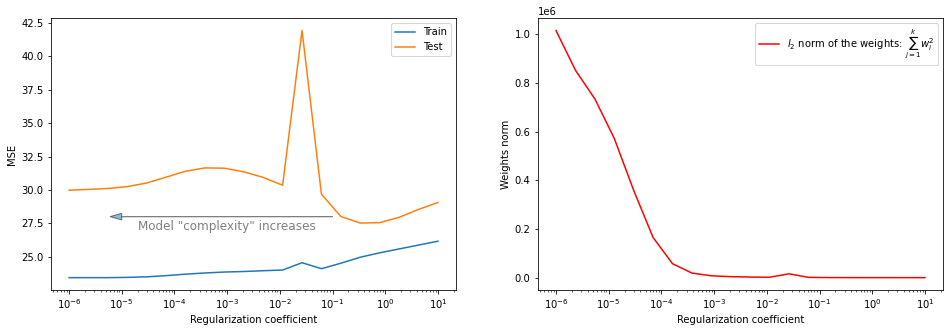

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(logspace, train_error, label='Train')
ax[0].plot(logspace, test_error, label='Test')
ax[0].set_xscale('log')
ax[0].legend();
ax[0].arrow(1e-1, 28, -(1e-1-1e-5), 0, head_width=0.5, head_length=.000004, alpha=.5);
ax[0].annotate('Model "complexity" increases', [2e-5, 27], size=12, alpha=0.5);
ax[0].set_xlabel('Regularization coefficient')
ax[0].set_ylabel('MSE')
ax[1].plot(logspace, weights, color='r', label='$l_2$ norm of the weights: $\sum_{j=1}^{k} w_i^2$')
ax[1].set_xscale('log')
ax[1].legend();
ax[1].set_ylabel('Weights norm')
ax[1].set_xlabel('Regularization coefficient');

In [21]:
np.argmin(test_error), logspace[np.argmin(test_error)]

(15, 0.3359818286283781)

In [23]:
logspace[15]

0.3359818286283781

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.00748e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


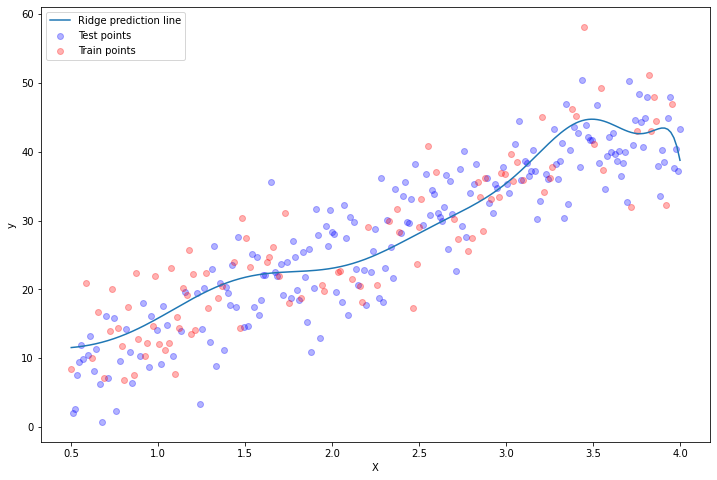

In [28]:
poly = PolynomialFeatures(degree=15, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_linspace_poly = poly.fit_transform(np.linspace(0.5,4,200).reshape(-1,1))

reg = Ridge(alpha = logspace[15], fit_intercept=True) # logspace[15]
reg.fit(X_train_poly, y_train)
y_pred_linspace = reg.predict(X_linspace_poly)

plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0.5,4,200), y_pred_linspace, label='Ridge prediction line')
plt.scatter(X_test, y_test, alpha=.3, c='b', label='Test points');
plt.scatter(X_train, y_train, alpha=.3, c='r', label='Train points');
plt.legend();
plt.xlabel('X')
plt.ylabel('y');

### Regularization is not a silver bullet

We do not get a perfect line, but sometimes it helps, compare to Linear Regression without regularization.

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.00748e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


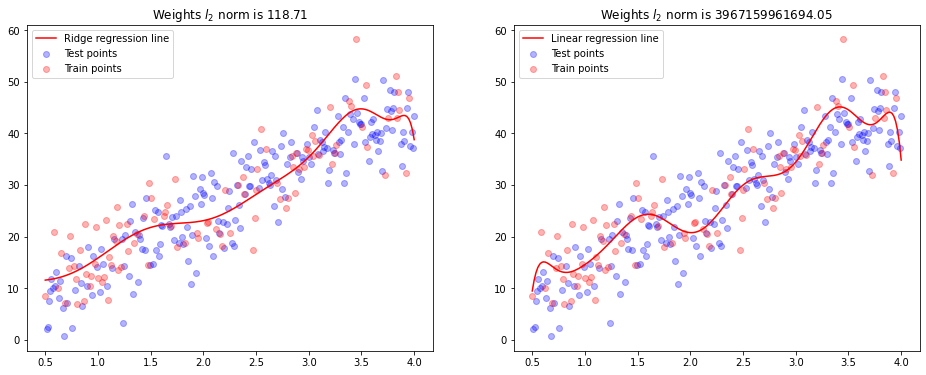

In [29]:
reg = Ridge(alpha = logspace[15], fit_intercept=True)
reg.fit(X_train_poly, y_train)
y_pred_linspace = reg.predict(X_linspace_poly)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(np.linspace(0.5,4,200), y_pred_linspace,c='r',label='Ridge regression line')
ax[0].scatter(X_test, y_test, alpha=.3, c='b', label='Test points');
w_norm_ridge = np.round(np.sum(reg.coef_**2), 2)
ax[0].set_title(f'Weights $l_2$ norm is {w_norm_ridge}')
ax[0].scatter(X_train, y_train, alpha=.3, c='r', label='Train points');
ax[0].legend()
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train_poly, y_train)
y_pred_linspace = reg.predict(X_linspace_poly)


w_norm_lr = np.round(np.sum(reg.coef_**2), 2)
ax[1].set_title(f'Weights $l_2$ norm is {w_norm_lr}')
ax[1].plot(np.linspace(0.5,4,200), y_pred_linspace,c='r', label='Linear regression line')
ax[1].scatter(X_test, y_test, alpha=.3,c='b', label='Test points');
ax[1].scatter(X_train, y_train, alpha=.3, c='r', label='Train points');
ax[1].legend();

# 2. K nearest kneighbors

> Complexity controlling parameter: number of neighbours, `n_neighbours`

In [30]:
from sklearn.neighbors import KNeighborsRegressor

### 2.1 Prediction curve

In [31]:
def plot_graph(reg, title):
    # Train a model
    reg.fit(X_train, y_train.reshape(-1))

    # Predict on a test data
    X_linspace = np.linspace(0.5,4,1000)[:, np.newaxis]
    y_pred_linspace = reg.predict(X_linspace)


    # Plot prediction curve
    plt.figure(figsize=(16, 12))
    plt.plot(X_linspace, y_pred_linspace, alpha=.3)
    for x1, x2, y1, y2 in zip(X_linspace[:-2], X_linspace[1:], y_pred_linspace[:-2], y_pred_linspace[1:]):
        if np.allclose(y1, y2):
            plt.plot([x1,x2], [y1,y2], c='r', lw=1)
        if (x1 <=3.2) and (x2 >=3.2):
            plt.scatter(3.2, y1, s=100, c='green', marker='x')
            plt.scatter(3.2, y1, s=140, edgecolors='green', facecolors='none')
    plt.plot([x1,x2], [y1,y2], c='r', lw=1, label='Prediction curve')
    plt.vlines(3.2,6, 60, colors='green', linestyles='--')
    plt.ylim(6, 60)

    plt.scatter(X_test, y_test, alpha=.3, c='b', label='Test points');
    plt.scatter(X_train, y_train, alpha=.3, c='r', label='Train points');
    plt.legend(loc='upper left');
    plt.title(f'{title}')

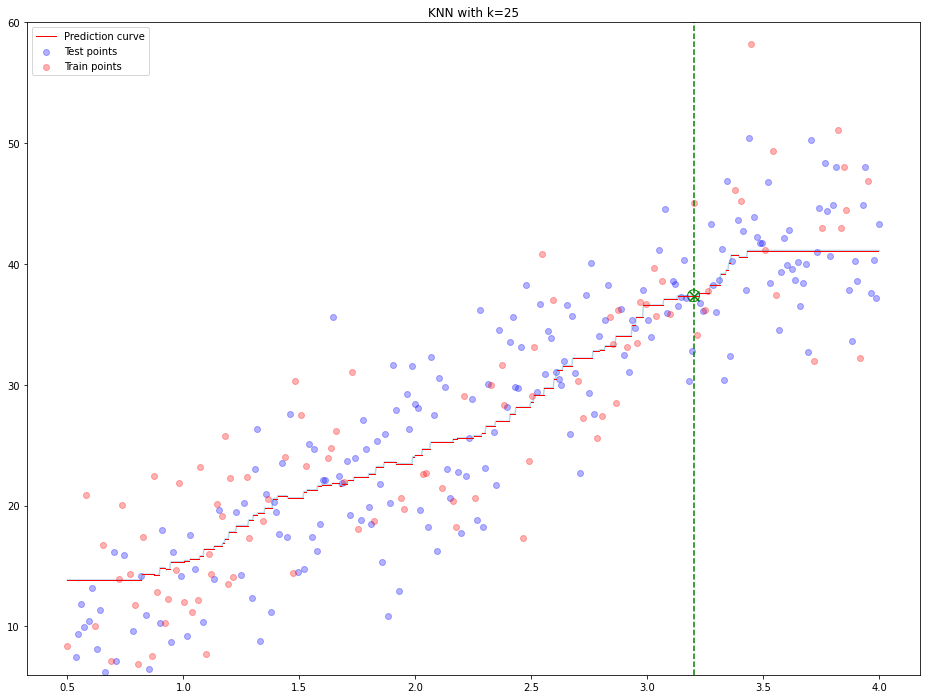

In [32]:
# Change number of neighbours from 99 to 1

n=25
reg = KNeighborsRegressor(n_neighbors=n)

plot_graph(reg, title=f'KNN with k={n}')

In [36]:
x_test = 3.2
x_neighbours = [3.1, 3.15, 3.3, 3.32, 3.12]
y_neigh_targ = [38,  36,   37,  40,    39]

# y_test = np.mean(y_neigh_targ)

# print(y_test)

In [37]:
KNeighborsRegressor()

KNeighborsRegressor()

### 2.2 Error curves

In [38]:
test_error = []
train_error = []
n=50
for n_neighbours in range(1, n):
        
    reg = KNeighborsRegressor(n_neighbours)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))

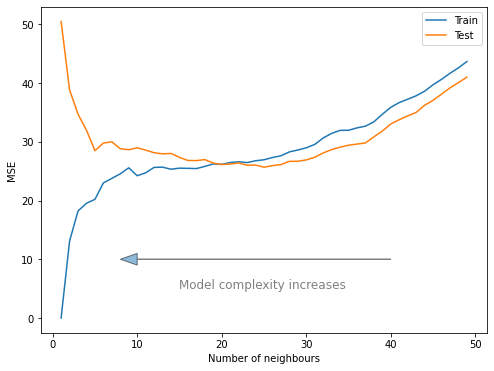

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, n), train_error, label='Train')
plt.plot(range(1, n), test_error, label='Test')
plt.legend();
plt.arrow(40, 10, -30, 0, head_width=2, head_length=2, alpha=.5)
plt.annotate('Model complexity increases', [15, 5], size=12, alpha=.5);
plt.xlabel('Number of neighbours')
plt.ylabel('MSE');

In [40]:
# Best model

n_neigh = list(range(1, n))[np.argmin(test_error)]
reg = KNeighborsRegressor(n_neighbors=n_neigh)
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print('Number of neighbours:',n_neigh, '\nTrain MSE:', mse(y_pred_train, y_train),'\nTest MSE:', mse(y_pred_test, y_test))

Number of neighbours: 25 
Train MSE: 26.94 
Test MSE: 25.67


# 3. Regression Tree

> Complexity controlling parameter: depth of the tree, `max_depth`

In [41]:
from sklearn.tree import DecisionTreeRegressor

### 3.1 Prediction curve

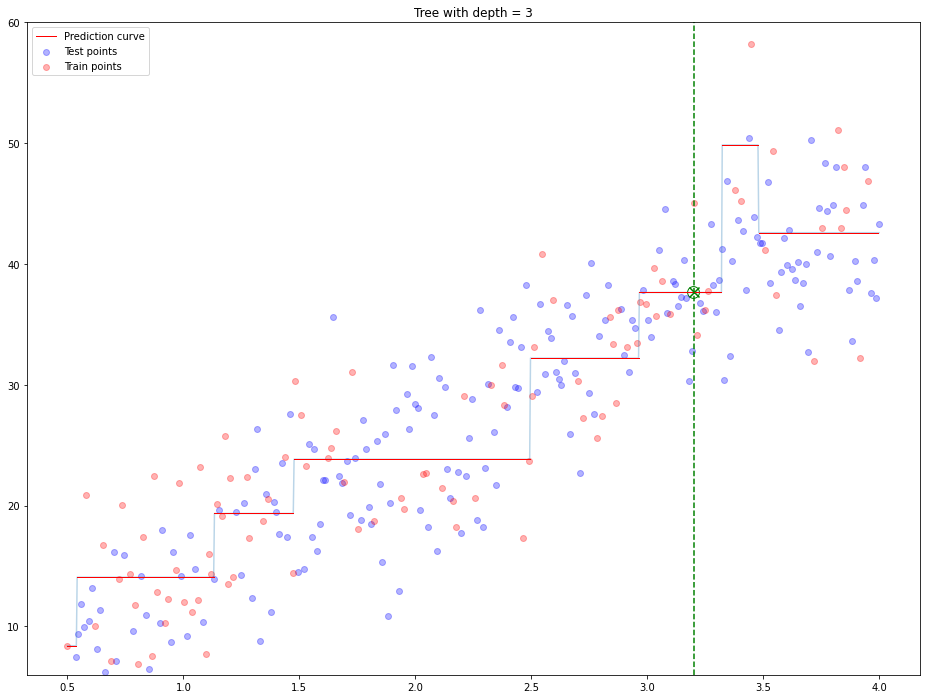

In [43]:
# Change max_depth from 1 to 20

depth=3
reg = DecisionTreeRegressor(max_depth=depth)

plot_graph(reg, title=f'Tree with depth = {depth}')

### 3.2 Error curves

In [44]:
test_error = []
train_error = []
n=20
for depth in range(1, n):
        
    reg = DecisionTreeRegressor(max_depth=depth)
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))

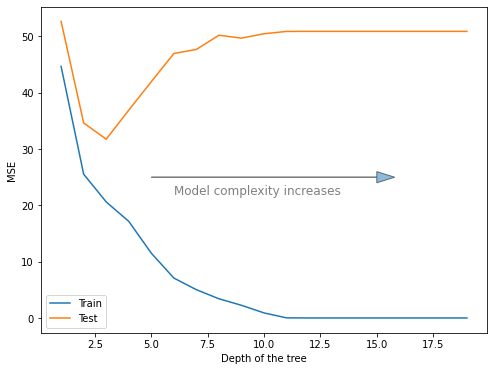

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, n), train_error, label='Train')
plt.plot(range(1, n), test_error, label='Test')
plt.legend();
plt.arrow(5, 25, 10, 0, head_width=2, head_length=.8, alpha=.5)
plt.annotate('Model complexity increases', [6, 22], size=12, alpha=.5);
plt.xlabel('Depth of the tree')
plt.ylabel('MSE');

In [46]:
# Best model

depth = list(range(1, n))[np.argmin(test_error)]
reg = DecisionTreeRegressor(max_depth=depth)
reg.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print('Depth of the tree:',n_neigh, '\nTrain MSE:', mse(y_pred_train, y_train),'\nTest MSE:', mse(y_pred_test, y_test))

Depth of the tree: 25 
Train MSE: 20.61 
Test MSE: 31.75


# 4. Gradient Boosting Trees

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

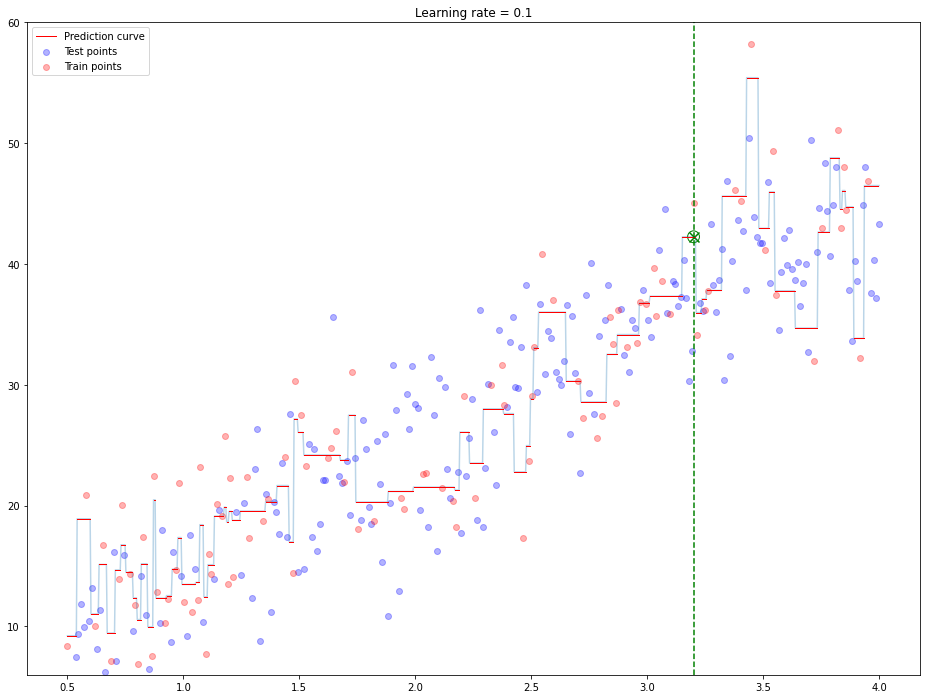

In [48]:
lr=0.1
reg = GradientBoostingRegressor(learning_rate=lr, n_estimators=100)

plot_graph(reg, title=f'Learning rate = {lr}')

In [50]:
from tqdm.notebook import tqdm

## Learning rate (fixed number of trees)

In [51]:
test_error = []
train_error = []
n=20
for lr in tqdm(np.logspace(-10, -1, num=n, base=3)):
        
    reg = GradientBoostingRegressor(learning_rate=lr, n_estimators=100)
    reg.fit(X_train, y_train.reshape(-1))
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))

  0%|          | 0/20 [00:00<?, ?it/s]

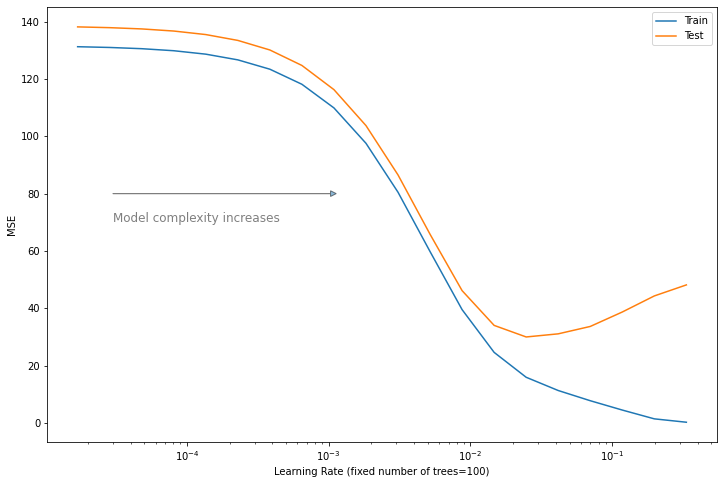

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(np.logspace(-10, -1, num=n, base=3), train_error, label='Train')
plt.plot(np.logspace(-10, -1, num=n, base=3), test_error, label='Test')
plt.xscale('log')
plt.legend();
plt.arrow(0.00003, 80, 0.001, 0, head_width=2, head_length=.0001, alpha=.5)
plt.annotate('Model complexity increases', [0.00003, 70], size=12, alpha=.5);
plt.xlabel('Learning Rate (fixed number of trees=100)')
plt.ylabel('MSE');

## Number of trees  (fixed learning rate)

In [53]:
np.round(np.logspace(2, 7, num=n, base=3)).astype(int)

array([   9,   12,   16,   21,   29,   38,   51,   68,   91,  121,  162,
        216,  289,  386,  515,  688,  919, 1227, 1638, 2187])

In [54]:
test_error = []
train_error = []
n=20
trees = np.round(np.logspace(2, 7, num=n, base=3)).astype(int)


for n_trees in tqdm(trees):
    reg = GradientBoostingRegressor(learning_rate=0.01, n_estimators=n_trees)
    reg.fit(X_train, y_train.reshape(-1))
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))

  0%|          | 0/20 [00:00<?, ?it/s]

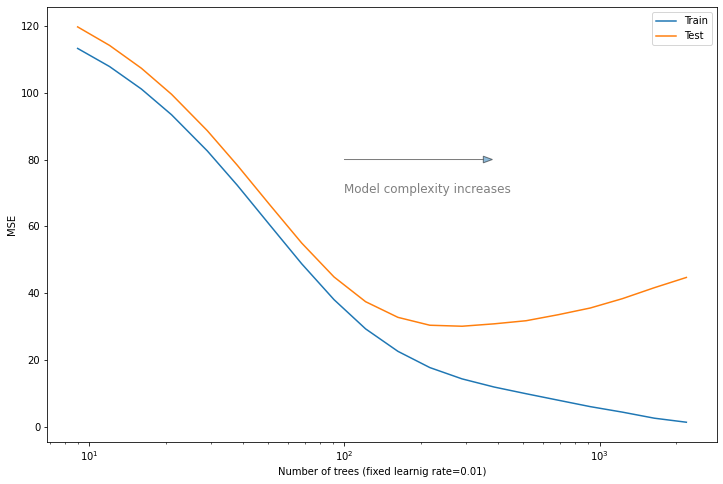

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(trees, train_error, label='Train')
plt.plot(trees, test_error, label='Test')
plt.xscale('log')
plt.legend();
plt.arrow(100, 80, 250, 0, head_width=2, head_length=30, alpha=.5)
plt.annotate('Model complexity increases', [100, 70], size=12, alpha=.5);
plt.xlabel('Number of trees (fixed learnig rate=0.01)')
plt.ylabel('MSE');

## `Learning rate` and `Number of trees`

In [56]:
# Define the range of learning rates and number of trees
lr_range = np.logspace(-8, -0.5, num=10, base=3)
trees_range = np.round(np.logspace(4, 8, num=10, base=3)).astype(int)

# Create meshgrid for learning rates and number of trees
lr_mesh, trees_mesh = np.meshgrid(lr_range, trees_range)

# Initialize arrays to store train and test MSE values
train_mse = np.zeros_like(lr_mesh)
test_mse = np.zeros_like(lr_mesh)

# Iterate over learning rates and number of trees
for i, lr in enumerate(tqdm(lr_range)):
    for j, n_trees in enumerate(trees_range):
        reg = GradientBoostingRegressor(learning_rate=lr, n_estimators=n_trees)
        reg.fit(X_train, y_train.reshape(-1))
        y_pred_train = reg.predict(X_train)
        y_pred_test = reg.predict(X_test)
        
        train_mse[j, i] = mse(y_pred_train, y_train)
        test_mse[j, i] = mse(y_pred_test, y_test)

  0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
trees_range

array([  81,  132,  215,  350,  571,  931, 1516, 2471, 4026, 6561])

In [58]:
lr_range

array([1.52415790e-04, 3.80742194e-04, 9.51112859e-04, 2.37592703e-03,
       5.93518342e-03, 1.48263822e-02, 3.70370370e-02, 9.25203531e-02,
       2.31120425e-01, 5.77350269e-01])

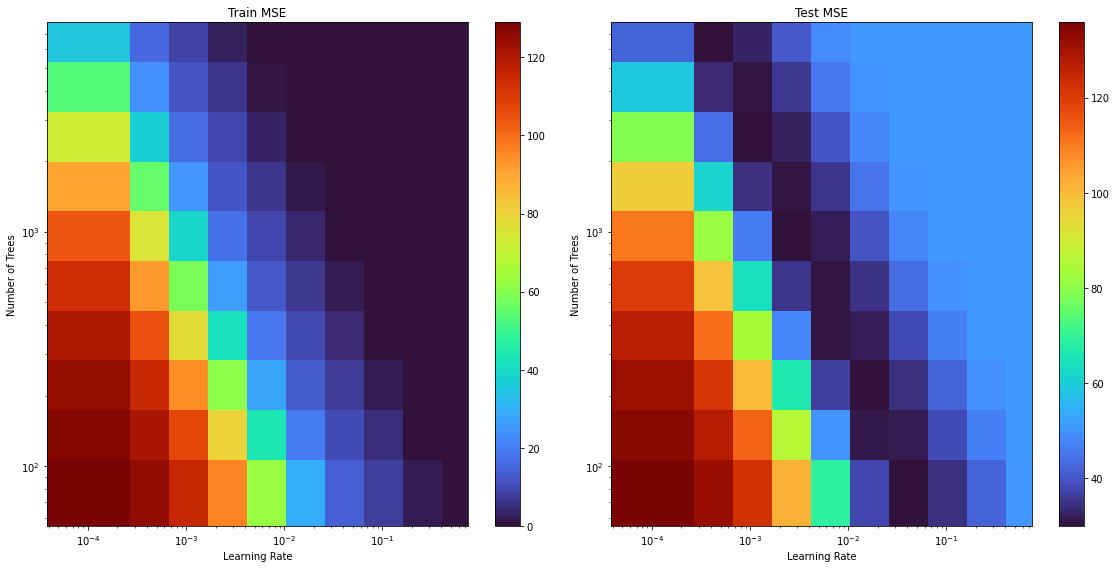

In [59]:
# Plot the colormaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Train MSE colormap
im1 = ax1.pcolormesh(lr_mesh, trees_mesh, train_mse, cmap='turbo', shading='auto')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Number of Trees')
ax1.set_title('Train MSE')
fig.colorbar(im1, ax=ax1)

# Test MSE colormap
im2 = ax2.pcolormesh(lr_mesh, trees_mesh, test_mse, cmap='turbo', shading='auto')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Number of Trees')
ax2.set_title('Test MSE')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Use `turbo` colormap, it is good for a wide variety of tasks
# https://blog.research.google/2019/08/turbo-improved-rainbow-colormap-for.html

Recall how the set of "optimal" combination of `learning rate` and `number of trees` follows a roughly linear trend, i.e. "increase learning rate x times, decrease number of trees x times". This allows training a GBT model with small number of trees (**faster training**) and a relatively large learning rate, tune **other** hyperparameters, and next simulteniously increase number of trees, and decrease learning rate.

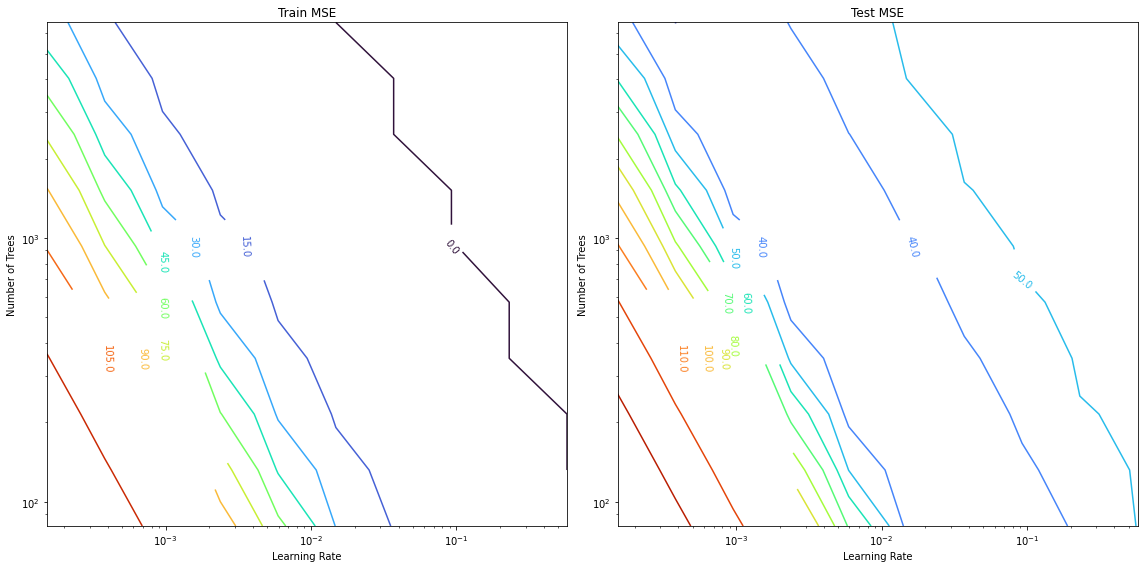

In [60]:
# Plot the level lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Train MSE level lines
cs1 = ax1.contour(lr_mesh, trees_mesh, train_mse, cmap='turbo', levels=10)
ax1.clabel(cs1, inline=True, fontsize=10, fmt='%.1f')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Number of Trees')
ax1.set_title('Train MSE')

# Test MSE level lines
cs2 = ax2.contour(lr_mesh, trees_mesh, test_mse, cmap='turbo', levels=10)
ax2.clabel(cs2, inline=True, fontsize=10, fmt='%.1f')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Number of Trees')
ax2.set_title('Test MSE')

plt.tight_layout()
plt.show()

# Individual `tree depth`

In [61]:
test_error = []
train_error = []
depth_grid = np.arange(1,15)


for depth in tqdm(depth_grid):
        
    reg = GradientBoostingRegressor(learning_rate=0.01, n_estimators=100, max_depth=depth)
    reg.fit(X_train, y_train.reshape(-1))
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    train_error.append(mse(y_pred_train, y_train))
    test_error.append(mse(y_pred_test, y_test))

  0%|          | 0/14 [00:00<?, ?it/s]

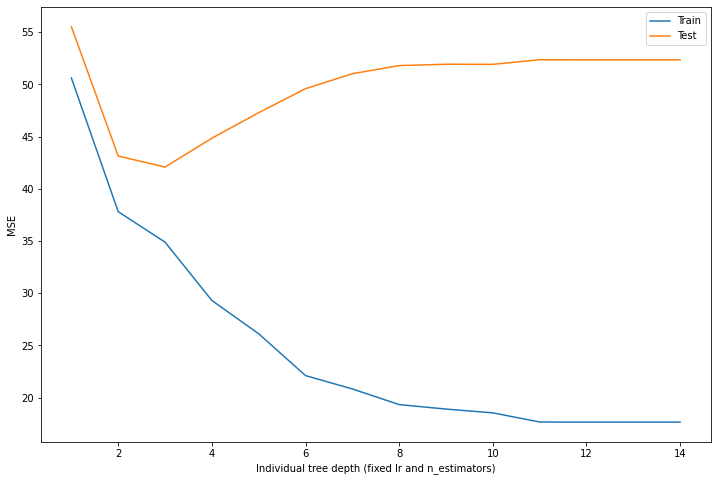

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(depth_grid, train_error, label='Train')
plt.plot(depth_grid, test_error, label='Test')
plt.legend();
plt.xlabel('Individual tree depth (fixed lr and n_estimators)')
plt.ylabel('MSE');